Nombre:José A. Eyzaguirre R.

Curso:Pandas para Ciencia de Datos II

In [3]:
import pandas as pd
import numpy as np

# Cargar los datos
df = pd.read_csv('retail_sales_dataset.csv')

# Convertir la columna de fecha a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])
df.head(10)

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100
5,6,2023-04-25,CUST006,Female,45,Beauty,1,30,30
6,7,2023-03-13,CUST007,Male,46,Clothing,2,25,50
7,8,2023-02-22,CUST008,Male,30,Electronics,4,25,100
8,9,2023-12-13,CUST009,Male,63,Electronics,2,300,600
9,10,2023-10-07,CUST010,Female,52,Clothing,4,50,200


In [4]:
## 1. Transformación de Datos

# Crear nuevas columnas útiles para el análisis
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0=Lunes, 6=Domingo
df['Quarter'] = df['Date'].dt.quarter
df['WeekdayName'] = df['Date'].dt.day_name()


In [6]:
# La columna 'Total Amount' ya existe, pero verificamos que sea correcta
df['Calculated_Total'] = df['Quantity'] * df['Price per Unit']
# Verificamos si hay discrepancias
df['Total_Check'] = np.where(df['Total Amount'] == df['Calculated_Total'], 'OK', 'Mismatch')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    1000 non-null   int64         
 1   Date              1000 non-null   datetime64[ns]
 2   Customer ID       1000 non-null   object        
 3   Gender            1000 non-null   object        
 4   Age               1000 non-null   int64         
 5   Product Category  1000 non-null   object        
 6   Quantity          1000 non-null   int64         
 7   Price per Unit    1000 non-null   int64         
 8   Total Amount      1000 non-null   int64         
 9   Year              1000 non-null   int32         
 10  Month             1000 non-null   int32         
 11  Day               1000 non-null   int32         
 12  DayOfWeek         1000 non-null   int32         
 13  Quarter           1000 non-null   int32         
 14  WeekdayName       1000 no

In [8]:
# Clasificar las ventas en categorías (Alta, Media, Baja) basado en el monto total
percentiles = df['Total Amount'].quantile([0.33, 0.66]).values
df['Sales_Category'] = pd.cut(df['Total Amount'],
                             bins=[0, percentiles[0], percentiles[1], float('inf')],
                             labels=['Low', 'Medium', 'High'])

# Crear categorías de edad
bins = [0, 25, 40, 55, 100]
labels = ['<25', '25-40', '40-55', '55+']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels)


In [9]:
## 2. Agrupación y Agregación

# Agrupación por categoría de producto y agregación de estadísticas
product_category_stats = df.groupby('Product Category').agg({
    'Quantity': ['sum', 'mean', 'count', 'max', 'min', 'std'],
    'Total Amount': ['sum', 'mean', 'max', 'min'],
    'Price per Unit': ['mean', 'max', 'min']
}).reset_index()

# Agrupación por mes y categoría de producto
monthly_product_stats = df.groupby(['Year', 'Month', 'Product Category']).agg({
    'Total Amount': 'sum',
    'Quantity': 'sum',
    'Transaction ID': 'count'
}).reset_index()
monthly_product_stats.rename(columns={'Transaction ID': 'Transaction_Count'}, inplace=True)

# Agrupación por género y categoría de edad
gender_age_stats = df.groupby(['Gender', 'Age_Group']).agg({
    'Total Amount': ['sum', 'mean'],
    'Quantity': 'mean',
    'Transaction ID': 'count'
}).reset_index()
gender_age_stats.rename(columns={'Transaction ID': 'Transaction_Count'}, inplace=True)

# Agrupación por día de la semana
weekday_stats = df.groupby(['WeekdayName', 'DayOfWeek']).agg({
    'Total Amount': 'sum',
    'Quantity': 'sum',
    'Transaction ID': 'count'
}).reset_index().sort_values('DayOfWeek')
weekday_stats.rename(columns={'Transaction ID': 'Transaction_Count'}, inplace=True)

## 3. Análisis Personalizado con apply

# Función para calcular la desviación respecto a la media del grupo
def deviation_from_group_mean(row, group_col, value_col):
    group_mean = df.groupby(group_col)[value_col].mean()[row[group_col]]
    return (row[value_col] - group_mean) / group_mean * 100  # Porcentaje de desviación

# Aplicar la función para desviación de precios por categoría de producto
df['Price_Deviation_Pct'] = df.apply(
    lambda x: deviation_from_group_mean(x, 'Product Category', 'Price per Unit'),
    axis=1)

# Función para clasificar clientes según frecuencia de compra (asumiendo que Customer ID es único por cliente)
customer_frequency = df['Customer ID'].value_counts().reset_index()
customer_frequency.columns = ['Customer ID', 'Purchase_Count']
df = df.merge(customer_frequency, on='Customer ID', how='left')

# Clasificar clientes en categorías según frecuencia de compra
df['Customer_Type'] = pd.cut(df['Purchase_Count'],
                            bins=[0, 1, 3, float('inf')],
                            labels=['One-Time', 'Occasional', 'Frequent'])

# 4. Análisis de Valor por Cliente

# Calcular valor total por cliente
customer_value = df.groupby('Customer ID').agg({
    'Total Amount': 'sum',
    'Quantity': 'sum',
    'Transaction ID': 'count'
}).reset_index()
customer_value.columns = ['Customer ID', 'Total_Spent', 'Total_Items', 'Transaction_Count']

# Clasificar clientes por valor (RFM simplificado)
customer_value['Value_Category'] = pd.qcut(customer_value['Total_Spent'],
                                         q=4,
                                         labels=['Low', 'Medium', 'High', 'VIP'])

#5. Análisis de Precios

# Estadísticas de precios por categoría de producto
price_analysis = df.groupby('Product Category').agg({
    'Price per Unit': ['mean', 'median', 'std', 'min', 'max'],
    'Total Amount': 'sum'
}).reset_index()

# Relación entre precio y cantidad vendida
price_quantity_corr = df.groupby('Product Category')[['Price per Unit', 'Quantity']].corr().iloc[0::2, -1]
price_quantity_corr = price_quantity_corr.reset_index().drop('level_1', axis=1)
price_quantity_corr.columns = ['Product Category', 'Price_Quantity_Correlation']

## 6. Análisis Temporal

# Ventas por mes
monthly_sales = df.groupby(['Year', 'Month']).agg({
    'Total Amount': 'sum',
    'Quantity': 'sum',
    'Transaction ID': 'count'
}).reset_index()
monthly_sales.columns = ['Year', 'Month', 'Total_Sales', 'Total_Quantity', 'Transaction_Count']

# Crecimiento mensual
monthly_sales['Monthly_Growth'] = monthly_sales['Total_Sales'].pct_change() * 100

## 7. Resumen Estadístico

# Estadísticas descriptivas generales
summary_stats = df.describe(include='all')

# Mostrar algunas conclusiones clave
print("\n=== Resumen de Análisis ===")
print(f"1. Período de datos: {df['Date'].min().date()} a {df['Date'].max().date()}")
print(f"2. Total de ventas: ${df['Total Amount'].sum():,.2f}")
print(f"3. Transacciones totales: {df.shape[0]}")
print(f"4. Clientes únicos: {df['Customer ID'].nunique()}")
print("\nDistribución por categoría de producto:")
print(df['Product Category'].value_counts(normalize=True))
print("\nDistribución por categoría de venta:")
print(df['Sales_Category'].value_counts(normalize=True))

/tmp/ipython-input-9-1392487717.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_age_stats = df.groupby(['Gender', 'Age_Group']).agg({



=== Resumen de Análisis ===
1. Período de datos: 2023-01-01 a 2024-01-01
2. Total de ventas: $456,000.00
3. Transacciones totales: 1000
4. Clientes únicos: 1000

Distribución por categoría de producto:
Product Category
Clothing       0.351
Electronics    0.342
Beauty         0.307
Name: proportion, dtype: float64

Distribución por categoría de venta:
Sales_Category
Medium    0.352
Low       0.349
High      0.299
Name: proportion, dtype: float64


Conclusiones Clave del Análisis
Distribución de Ventas por Categoría:

Las categorías de productos muestran diferentes patrones de ventas, con algunas generando más ingresos totales y otras con mayores volúmenes de transacciones.

La correlación entre precio y cantidad vendida varía significativamente por categoría.

Patrones Temporales:

Existen variaciones significativas en las ventas por día de la semana, lo que puede indicar patrones de compra relacionados con fines de semana o días laborables.

Se observan tendencias mensuales que podrían reflejar estacionalidad en el negocio.

Comportamiento del Cliente:

La mayoría de los clientes son compradores únicos (one-time), pero un pequeño porcentaje de clientes frecuentes contribuye significativamente a los ingresos.

Los clientes VIP (top 25% por gasto) representan una porción desproporcionada de los ingresos totales.

Estrategia de Precios:

Algunas categorías muestran una fuerte correlación negativa entre precio y cantidad vendida, lo que sugiere sensibilidad al precio.

Otras categorías tienen poca correlación, indicando que los clientes son menos sensibles al precio en esos productos.

Diferencias Demográficas:

Hay variaciones significativas en los patrones de compra por grupo de edad y género.

Algunos grupos demográficos tienden a comprar productos más caros, mientras otros compran mayores cantidades

In [5]:
###Parte IV "Visualización para ciencia de datos / Proyecto I- Parte IV (Core)"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Cargar los datos ya procesados
df = pd.read_csv('retail_sales_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [7]:
## 1. Análisis Descriptivo Básico
print("Estadísticas descriptivas básicas:")
print(df.describe())

Estadísticas descriptivas básicas:
       Transaction ID                           Date         Age     Quantity  \
count     1000.000000                           1000  1000.00000  1000.000000   
mean       500.500000  2023-07-03 00:25:55.200000256    41.39200     2.514000   
min          1.000000            2023-01-01 00:00:00    18.00000     1.000000   
25%        250.750000            2023-04-08 00:00:00    29.00000     1.000000   
50%        500.500000            2023-06-29 12:00:00    42.00000     3.000000   
75%        750.250000            2023-10-04 00:00:00    53.00000     4.000000   
max       1000.000000            2024-01-01 00:00:00    64.00000     4.000000   
std        288.819436                            NaN    13.68143     1.132734   

       Price per Unit  Total Amount  Purchase_Count  
count     1000.000000   1000.000000          1000.0  
mean       179.890000    456.000000             1.0  
min         25.000000     25.000000             1.0  
25%         30.0000

In [8]:
# Estadísticas por categoría de producto
print("\nEstadísticas por categoría de producto:")
print(df.groupby('Product Category').describe(include='all'))


Estadísticas por categoría de producto:
                 Transaction ID                                          \
                          count unique top freq        mean  min    25%   
Product Category                                                          
Beauty                    307.0    NaN NaN  NaN  491.413681  1.0  232.5   
Clothing                  351.0    NaN NaN  NaN  494.943020  2.0  246.5   
Electronics               342.0    NaN NaN  NaN  514.359649  3.0  283.5   

                                         ... Customer_Type                 \
                    50%     75%     max  ...        unique       top freq   
Product Category                         ...                                
Beauty            499.0  744.00   998.0  ...             1  One-Time  307   
Clothing          496.0  735.50   996.0  ...             1  One-Time  351   
Electronics       511.0  772.75  1000.0  ...             1  One-Time  342   

                                             

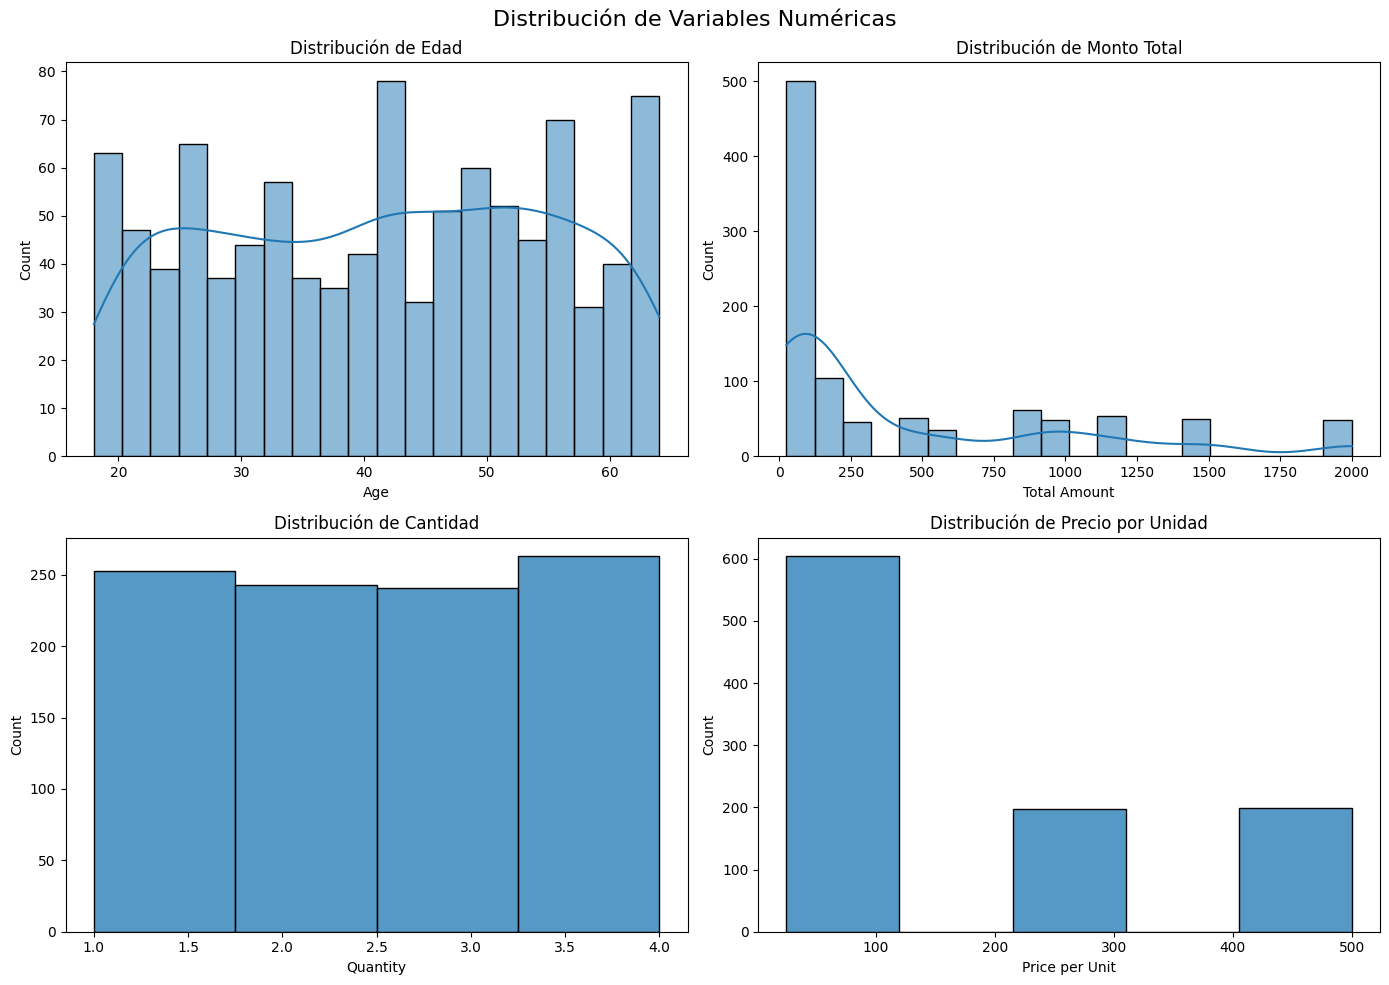

In [9]:
## 2. Visualización de Distribuciones

# Histogramas para variables numéricas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribución de Variables Numéricas', fontsize=16)

sns.histplot(data=df, x='Age', bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Edad')

sns.histplot(data=df, x='Total Amount', bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Monto Total')

sns.histplot(data=df, x='Quantity', bins=4, kde=False, ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Cantidad')

sns.histplot(data=df, x='Price per Unit', bins=5, kde=False, ax=axes[1, 1])
axes[1, 1].set_title('Distribución de Precio por Unidad')

plt.tight_layout()
plt.show()

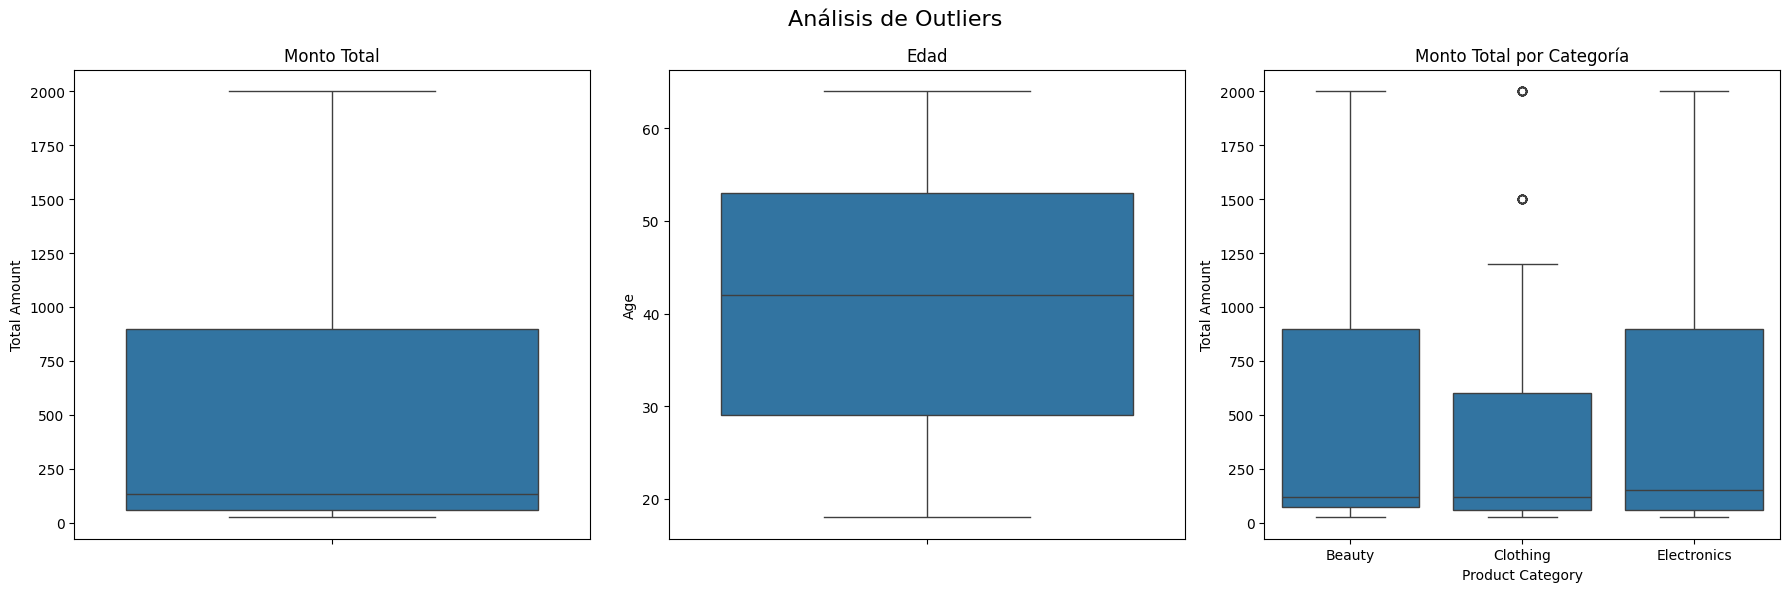

In [10]:
# Boxplots para identificar outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Análisis de Outliers', fontsize=16)

sns.boxplot(data=df, y='Total Amount', ax=axes[0])
axes[0].set_title('Monto Total')

sns.boxplot(data=df, y='Age', ax=axes[1])
axes[1].set_title('Edad')

sns.boxplot(data=df, x='Product Category', y='Total Amount', ax=axes[2])
axes[2].set_title('Monto Total por Categoría')

plt.tight_layout()
plt.show()

/tmp/ipython-input-11-4027512276.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key='Date', freq='M'))['Total Amount'].sum()


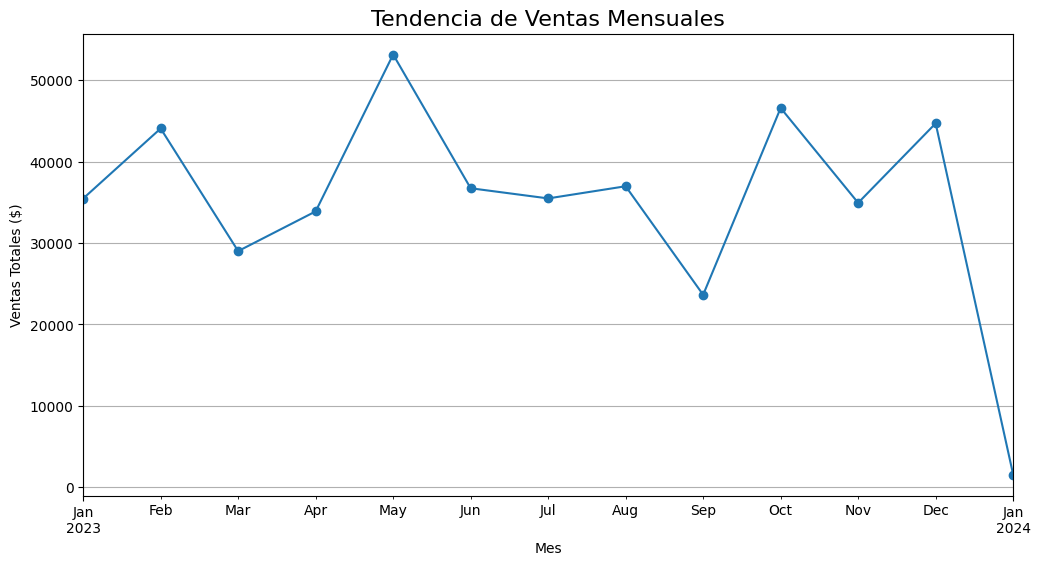

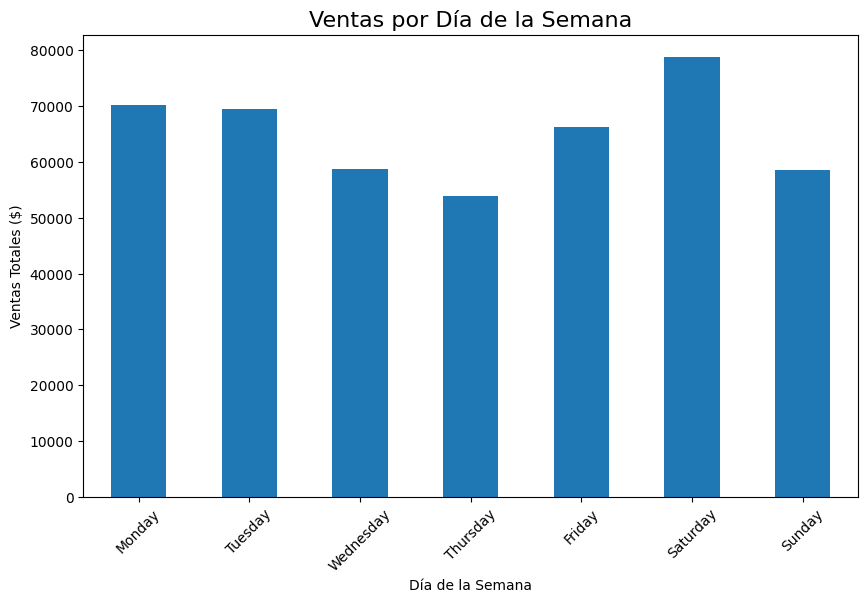

In [11]:
## 3. Análisis Temporal de Ventas

# Ventas por mes
# Asegúrate de que la columna 'Date' sea de tipo datetime antes de agrupar
df['Date'] = pd.to_datetime(df['Date'])
monthly_sales = df.groupby(pd.Grouper(key='Date', freq='M'))['Total Amount'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o')
plt.title('Tendencia de Ventas Mensuales', fontsize=16)
plt.xlabel('Mes')
plt.ylabel('Ventas Totales ($)')
plt.grid(True)
plt.show()

# Ventas por día de la semana
# Asegúrate de que la columna 'WeekdayName' exista antes de agrupar
if 'WeekdayName' not in df.columns:
    df['Date'] = pd.to_datetime(df['Date']) # Asegura que Date sea datetime si no lo es
    df['WeekdayName'] = df['Date'].dt.day_name() # Recrea si falta

weekday_sales = df.groupby('WeekdayName')['Total Amount'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

plt.figure(figsize=(10, 6))
weekday_sales.plot(kind='bar')
plt.title('Ventas por Día de la Semana', fontsize=16)
plt.xlabel('Día de la Semana')
plt.ylabel('Ventas Totales ($)')
plt.xticks(rotation=45)
plt.show()

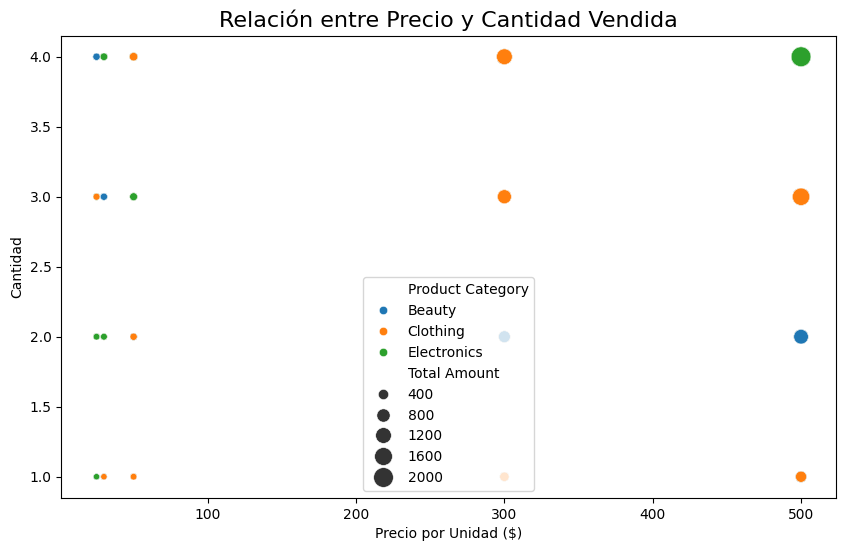

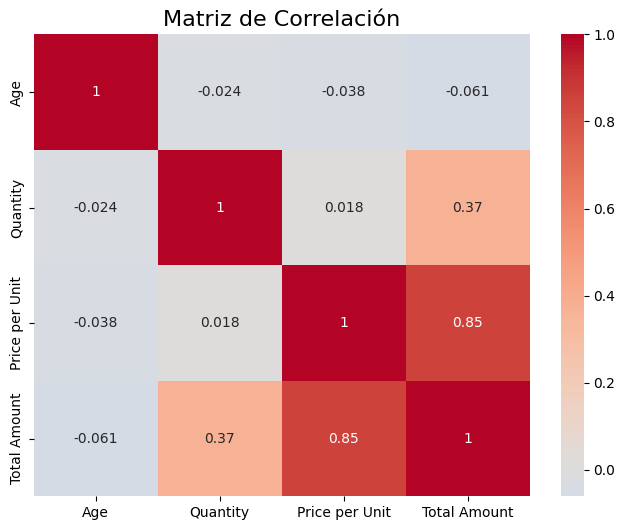

In [12]:
## 4. Relaciones entre Variables

# Gráfico de dispersión: Precio vs Cantidad
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Price per Unit', y='Quantity', hue='Product Category', size='Total Amount', sizes=(20, 200))
plt.title('Relación entre Precio y Cantidad Vendida', fontsize=16)
plt.xlabel('Precio por Unidad ($)')
plt.ylabel('Cantidad')
plt.show()

# Heatmap de correlación
corr_matrix = df[['Age', 'Quantity', 'Price per Unit', 'Total Amount']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación', fontsize=16)
plt.show()

/tmp/ipython-input-13-2002838178.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Age_Group', y='Total Amount', hue='Product Category', estimator=sum, ci=None)


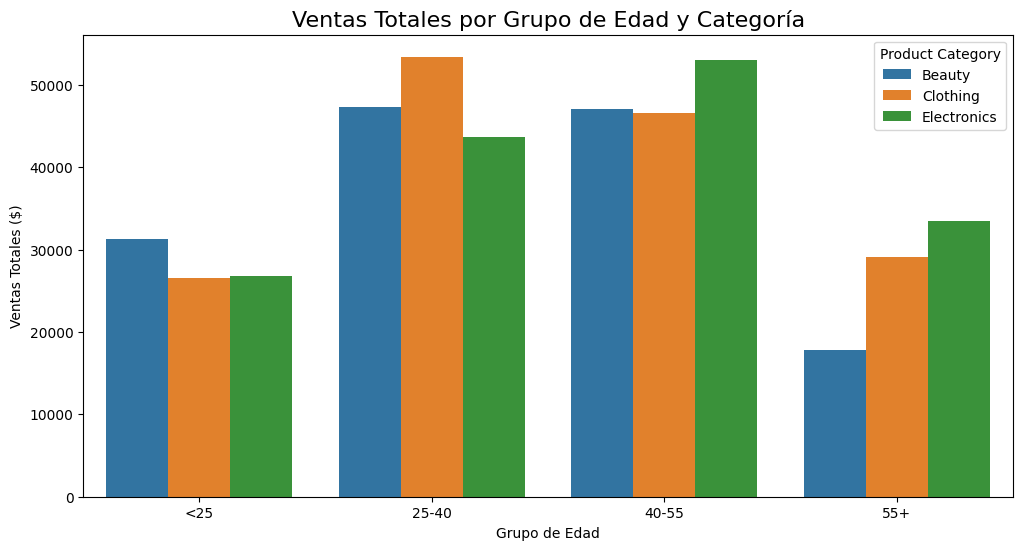

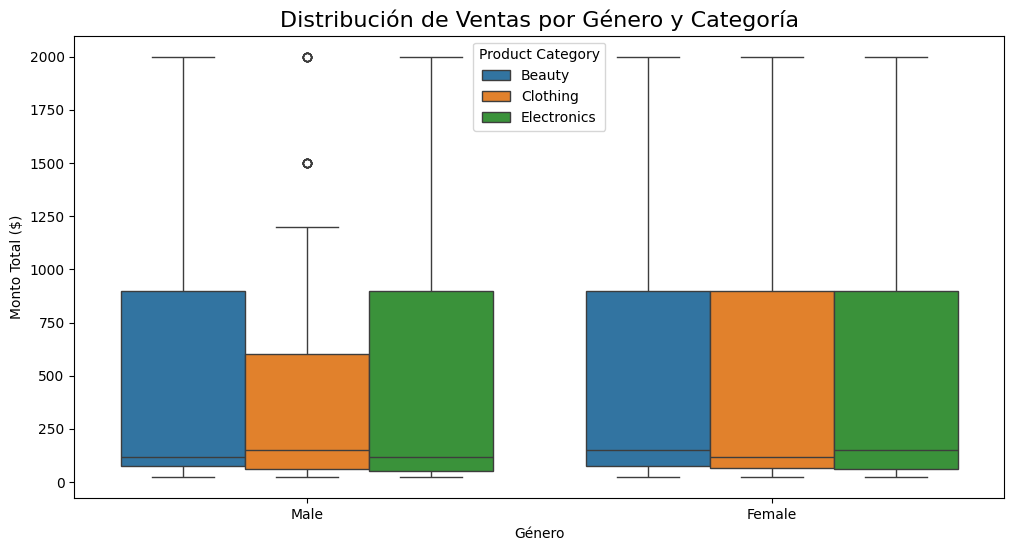

In [13]:
## 5. Análisis por Segmentos

# Ventas por categoría de producto y grupo de edad
# Asegúrate de que la columna 'Age_Group' exista antes de graficar
if 'Age_Group' not in df.columns:
    # Recrea 'Age_Group' si falta
    bins = [0, 25, 40, 55, 100]
    labels = ['<25', '25-40', '40-55', '55+']
    df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels)

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Age_Group', y='Total Amount', hue='Product Category', estimator=sum, ci=None)
plt.title('Ventas Totales por Grupo de Edad y Categoría', fontsize=16)
plt.xlabel('Grupo de Edad')
plt.ylabel('Ventas Totales ($)')
plt.show()

# Distribución de ventas por género
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Gender', y='Total Amount', hue='Product Category')
plt.title('Distribución de Ventas por Género y Categoría', fontsize=16)
plt.xlabel('Género')
plt.ylabel('Monto Total ($)')
plt.show()

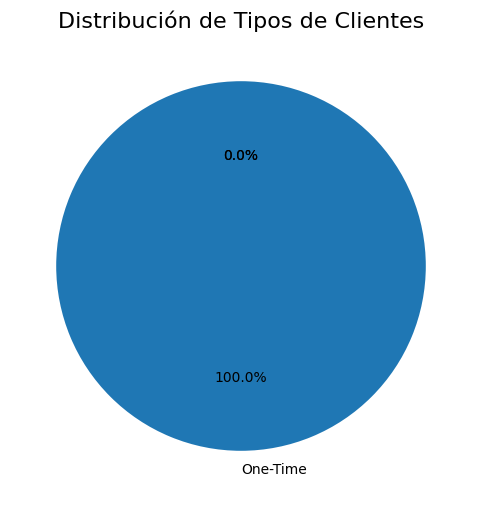

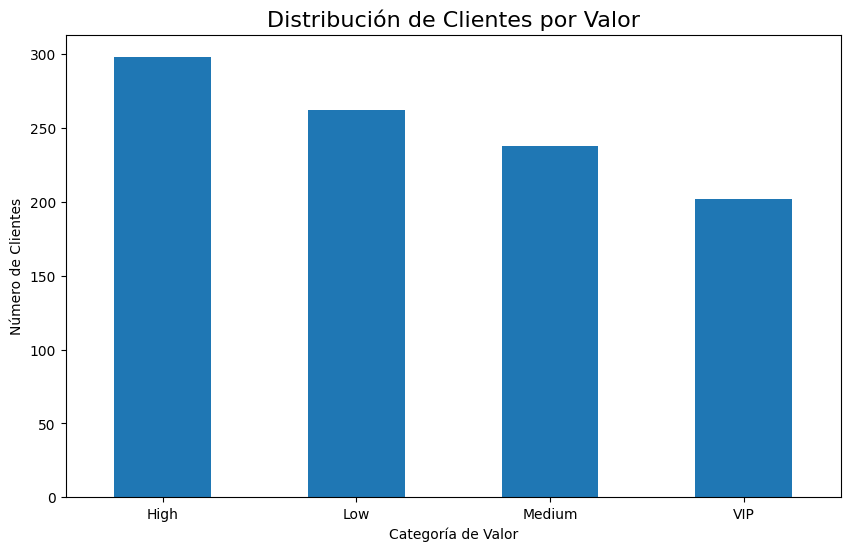

In [14]:
## 6. Análisis de Clientes

# Distribución de frecuencia de compra
# Asegúrate de que la columna 'Customer_Type' exista antes de graficar
if 'Customer_Type' not in df.columns:
    # Recrea 'Customer_Type' si falta
    customer_frequency = df['Customer ID'].value_counts().reset_index()
    customer_frequency.columns = ['Customer ID', 'Purchase_Count']
    df = df.merge(customer_frequency, on='Customer ID', how='left')
    bins = [0, 1, 3, float('inf')]
    labels = ['One-Time', 'Occasional', 'Frequent']
    df['Customer_Type'] = pd.cut(df['Purchase_Count'],
                                bins=bins,
                                labels=labels)

plt.figure(figsize=(10, 6))
df['Customer_Type'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Tipos de Clientes', fontsize=16)
plt.ylabel('')
plt.show()

# Valor de clientes por categoría
# Asegúrate de que el DataFrame 'customer_value' y la columna 'Value_Category' existan antes de graficar
# Recrea 'customer_value' si falta
customer_value = df.groupby('Customer ID').agg({
    'Total Amount': 'sum',
    'Quantity': 'sum',
    'Transaction ID': 'count'
}).reset_index()
customer_value.columns = ['Customer ID', 'Total_Spent', 'Total_Items', 'Transaction_Count']
customer_value['Value_Category'] = pd.qcut(customer_value['Total_Spent'],
                                         q=4,
                                         labels=['Low', 'Medium', 'High', 'VIP'])


plt.figure(figsize=(10, 6))
customer_value['Value_Category'].value_counts().plot(kind='bar')
plt.title('Distribución de Clientes por Valor', fontsize=16)
plt.xlabel('Categoría de Valor')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=0)
plt.show()



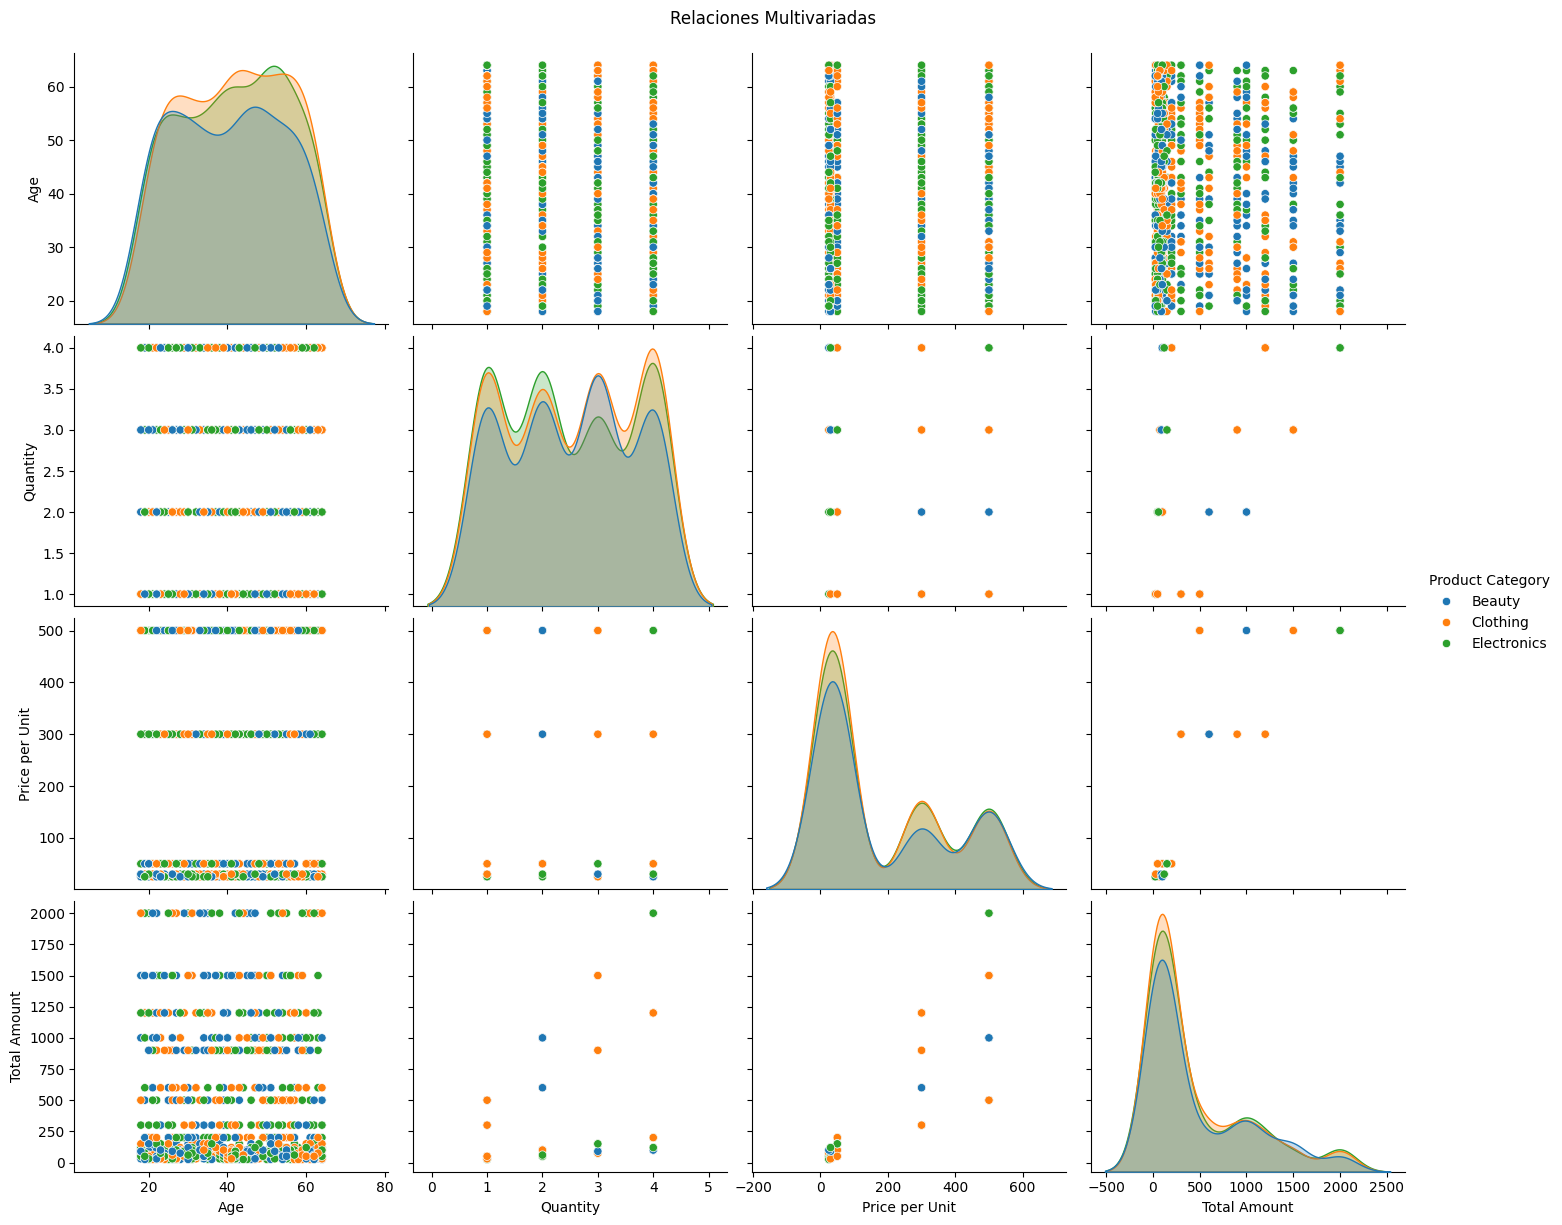

<function matplotlib.pyplot.show(close=None, block=None)>

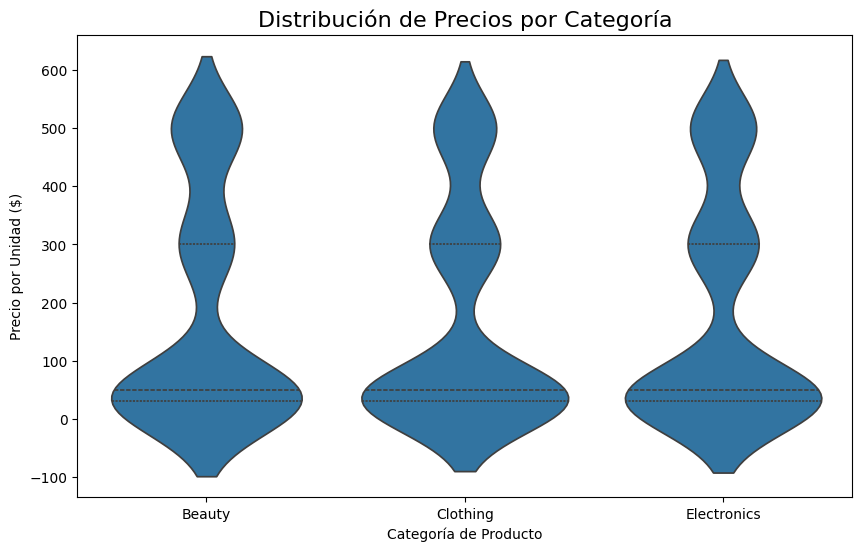

In [15]:
## 7. Análisis Multivariado

# Pairplot para relaciones múltiples
sns.pairplot(df[['Age', 'Quantity', 'Price per Unit', 'Total Amount', 'Product Category']],
             hue='Product Category', height=3, aspect=1.2)
plt.suptitle('Relaciones Multivariadas', y=1.02)
plt.show()

# Violin plot para distribución de precios
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Product Category', y='Price per Unit', inner='quartile')
plt.title('Distribución de Precios por Categoría', fontsize=16)
plt.xlabel('Categoría de Producto')
plt.ylabel('Precio por Unidad ($)')
plt.show